( Ignore this first code section. It's just basic setup. )

In [1]:
import pandas
import numpy
import itertools
from collections import OrderedDict
from IPython.display import Image

def color_nan(x):
    if x is numpy.nan:
        return "background-color: #e1b2be; border-color: white"
    else:
        return "background-color: #eff5f5; border-color: white"

DEBUG=False

def debug(*args):
    if DEBUG:
        display_nans(*args)
        
def display_nans(*args):
    for thing in args:
        if isinstance(thing, pandas.DataFrame):
            display(thing.sort_index(axis=1).style.hide_index().applymap(color_nan))
        else:
            print(thing)

def yellow_cols(s, columns):
    if s.name in columns:
        return s.apply(
            lambda x: "background-color: #ffff99; border-color: white" if x is not numpy.nan else "background-color: #F0D9AC; border-color: white"
        )
    else:
        return [""]*len(s)
    
def color_suffixes(df, suffixes):
    cols_to_color = []
    for s in suffixes:
        for col in df.columns:
            if col.endswith(s):
                cols_to_color.append(col)
    display(df.style.hide_index().applymap(color_nan).apply(yellow_cols, columns=cols_to_color, axis=0))

def current_merge(left, right):
    return left.merge(right, how="outer")
    
def sequential_outer_merge(*args):
    ret = None
    for df in args:
        if ret is None:
            ret = df
        else:
            ret = current_merge(ret, df)
    return ret

def show_sequential_outer_merge_permutations(*args):
    for p in itertools.permutations(args):
        display_nans(
            sequential_outer_merge(*p)
        )
        
def run_test(*args):
    function = args[-1]
    print("-"*50)
    print("inputs")
    display_nans(*args[:-1])
    print("output")
    display_nans(function(*args[:-1]))

---
# The Dangers Of Naively Preserving Source Data's Tabular Nature, From Zero Knowledge Onward
---

* ## Merge Bubbles From Partial Batches:

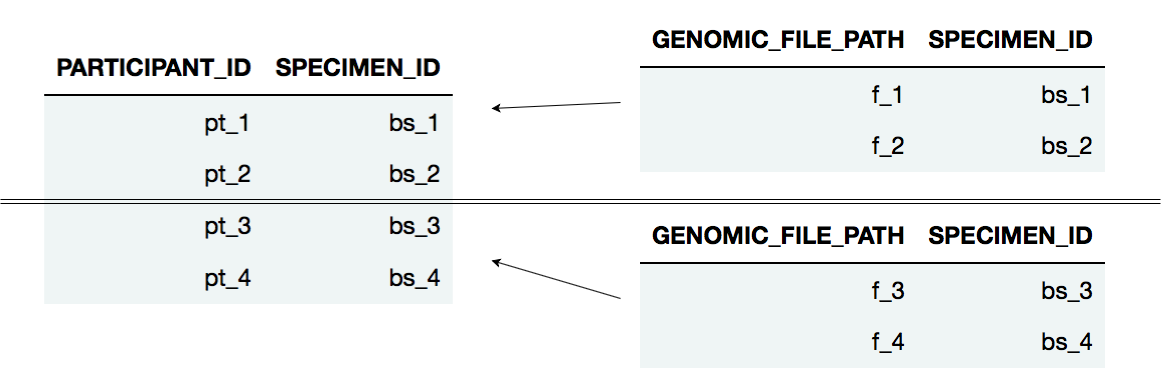

In [2]:
df1 = pandas.DataFrame({
    'PARTICIPANT_ID':['pt_1','pt_2','pt_3','pt_4'], 
    'SPECIMEN_ID':['bs_1','bs_2','bs_3','bs_4']
})

df2 = pandas.DataFrame({
    'SPECIMEN_ID':['bs_1','bs_2'],
    'GENOMIC_FILE_PATH':['f_1','f_2'],
})

df3 = pandas.DataFrame({
    'SPECIMEN_ID':['bs_3','bs_4'],
    'GENOMIC_FILE_PATH':['f_3','f_4']
})

Image("img/Partial_Batches.png")

#### When merging these DFs, we can intuitively say that we really want to get this:

```
     GENOMIC_FILE_PATH  PARTICIPANT_ID  SPECIMEN_ID
0    f_1                pt_1            se_1
1    f_2                pt_2            se_2
2    f_3                pt_3            se_3
3    f_4                pt_4            se_4
```

#### but most merge orders don't get us there...




In [3]:
show_sequential_outer_merge_permutations(df1, df2, df3)

GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_1,pt_1,bs_1
f_2,pt_2,bs_2
nan,pt_3,bs_3
nan,pt_4,bs_4
f_3,nan,bs_3
f_4,nan,bs_4


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
nan,pt_1,bs_1
nan,pt_2,bs_2
f_3,pt_3,bs_3
f_4,pt_4,bs_4
f_1,nan,bs_1
f_2,nan,bs_2


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_1,pt_1,bs_1
f_2,pt_2,bs_2
nan,pt_3,bs_3
nan,pt_4,bs_4
f_3,nan,bs_3
f_4,nan,bs_4


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_1,pt_1,bs_1
f_2,pt_2,bs_2
f_3,pt_3,bs_3
f_4,pt_4,bs_4


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_3,pt_3,bs_3
f_4,pt_4,bs_4
nan,pt_1,bs_1
nan,pt_2,bs_2
f_1,nan,bs_1
f_2,nan,bs_2


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_3,pt_3,bs_3
f_4,pt_4,bs_4
f_1,pt_1,bs_1
f_2,pt_2,bs_2


#### Only the results that minimize the final row count are good. (Avi is 50% sure that this is the right metric at this stage)

In [4]:
def minimum_length_batch_merge(*args):
    shortest = None
    for p in itertools.permutations(args):
        try:
            df = sequential_outer_merge(*p)
            if shortest is None:
                shortest = df
            elif len(df) < len(shortest):
                shortest = df
        except Exception as e:
            print(e)
            pass
    return shortest

def show_minimum_length_batch_merge(*args):
    display_nans(minimum_length_batch_merge(*args))
        
run_test(df1, df2, df3, minimum_length_batch_merge)

--------------------------------------------------
inputs


PARTICIPANT_ID,SPECIMEN_ID
pt_1,bs_1
pt_2,bs_2
pt_3,bs_3
pt_4,bs_4


GENOMIC_FILE_PATH,SPECIMEN_ID
f_1,bs_1
f_2,bs_2


GENOMIC_FILE_PATH,SPECIMEN_ID
f_3,bs_3
f_4,bs_4


output


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_1,pt_1,bs_1
f_2,pt_2,bs_2
f_3,pt_3,bs_3
f_4,pt_4,bs_4


#### Good enough for now, but...

* ## Merge Bubbles From Partial Overlap:

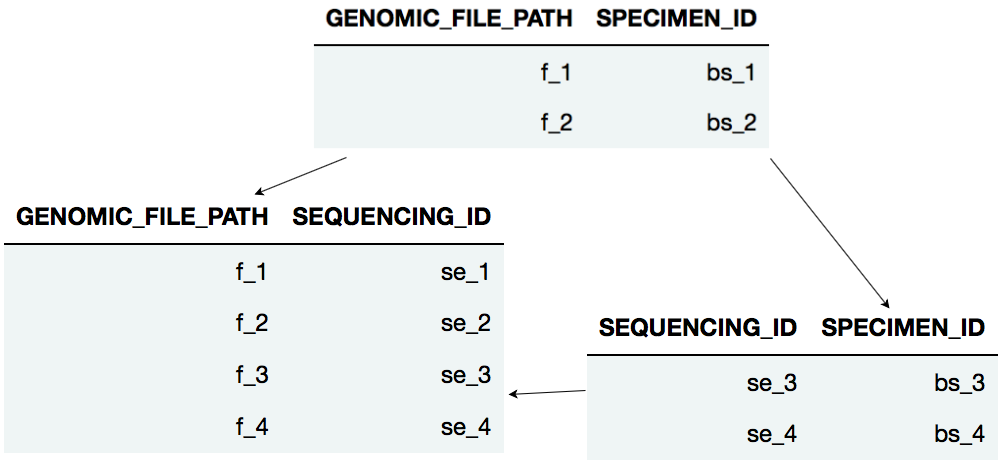

In [5]:
df4 = pandas.DataFrame({
    'SPECIMEN_ID':['bs_1','bs_2'], 
    'GENOMIC_FILE_PATH':['f_1','f_2']
})

df5 = pandas.DataFrame({
    'SEQUENCING_ID':['se_1','se_2','se_3','se_4'], 
    'GENOMIC_FILE_PATH':['f_1','f_2','f_3','f_4']
})

df6 = pandas.DataFrame({
    'SPECIMEN_ID':['bs_3','bs_4'], 
    'SEQUENCING_ID':['se_3','se_4']
})

Image("img/Partial_Overlap.png")

#### When merging these DFs, we can intuitively say that we really want to get

```
     SPECIMEN_ID  GENOMIC_FILE_PATH  SEQUENCING_ID
0    bs_1         f_1                se_1
1    bs_2         f_2                se_2
2    bs_3         f_3                se_3
3    bs_4         f_4                se_4 
```
#### That would express the nature of the identification relationship connecting Specimen, Genomic File, and Sequencing Experiment.


#### But these relationships are lost to bubbles regardless of merge order.


In [6]:
show_sequential_outer_merge_permutations(df4, df5, df6)

GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,nan
f_4,se_4,nan
nan,se_3,bs_3
nan,se_4,bs_4


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,nan,bs_1
f_2,nan,bs_2
nan,se_3,bs_3
nan,se_4,bs_4
f_1,se_1,nan
f_2,se_2,nan
f_3,se_3,nan
f_4,se_4,nan


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,nan
f_4,se_4,nan
nan,se_3,bs_3
nan,se_4,bs_4


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,nan
f_2,se_2,nan
f_3,se_3,bs_3
f_4,se_4,bs_4
f_1,nan,bs_1
f_2,nan,bs_2


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
nan,se_3,bs_3
nan,se_4,bs_4
f_1,nan,bs_1
f_2,nan,bs_2
f_1,se_1,nan
f_2,se_2,nan
f_3,se_3,nan
f_4,se_4,nan


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_3,se_3,bs_3
f_4,se_4,bs_4
f_1,se_1,nan
f_2,se_2,nan
f_1,nan,bs_1
f_2,nan,bs_2


#### <span style="color:red">That's bad.</span> The main problem is that Pandas doesn't remember from one merge to the next which nans are real data and which ones are just merge artifacts. 

### So next we try to make a merge that rectifies null/non-null overlaps.

#### 1. First just mark the null/non-null overlaps while merging

In [7]:
def marking_merge(left, right):
    sl = "_left_"
    sr = "_right_"

    overlap = set(left.columns).intersection(set(right.columns))
    if not overlap:
        raise Exception("No overlapping columns.")

    # I think we can only merge data for rows where the join columns don't all contain nans
    right = right.dropna(subset=overlap)

    # Find the outer join columns that produce the fewest resulting rows.
    # Don't fret too much about the performance cost of looping through many merges.
    # It's still plenty fast enough.
    df = None
    for n in range(len(overlap), 0, -1):
        for o in itertools.combinations(overlap, n):
            temp_df = pandas.merge(
                # Setting the on and suffixes arguments is what lets us do our magic.
                # Instead of creating new rows on null/non-null value overlaps, 
                # pandas will create parallel left/right columns instead.
                left, right, how="outer", on=o, suffixes=(sl, sr)
            )
            if df is None or (len(temp_df) < len(df)):
                df = temp_df
    return df

current_merge = marking_merge

for p in itertools.permutations([df4, df5, df6]):
    color_suffixes(sequential_outer_merge(*p), suffixes=["_left_", "_right_"])

SPECIMEN_ID_left_,GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID_right_
bs_1,f_1,se_1,nan
bs_2,f_2,se_2,nan
nan,f_3,se_3,bs_3
nan,f_4,se_4,bs_4


SPECIMEN_ID,GENOMIC_FILE_PATH_left_,SEQUENCING_ID,GENOMIC_FILE_PATH_right_
bs_1,f_1,nan,nan
bs_2,f_2,nan,nan
bs_3,nan,se_3,f_3
bs_4,nan,se_4,f_4
nan,nan,se_1,f_1
nan,nan,se_2,f_2


SEQUENCING_ID,GENOMIC_FILE_PATH,SPECIMEN_ID_left_,SPECIMEN_ID_right_
se_1,f_1,bs_1,nan
se_2,f_2,bs_2,nan
se_3,f_3,nan,bs_3
se_4,f_4,nan,bs_4


SEQUENCING_ID,GENOMIC_FILE_PATH,SPECIMEN_ID_left_,SPECIMEN_ID_right_
se_1,f_1,nan,bs_1
se_2,f_2,nan,bs_2
se_3,f_3,bs_3,nan
se_4,f_4,bs_4,nan


SPECIMEN_ID,SEQUENCING_ID,GENOMIC_FILE_PATH_left_,GENOMIC_FILE_PATH_right_
bs_3,se_3,nan,f_3
bs_4,se_4,nan,f_4
bs_1,nan,f_1,nan
bs_2,nan,f_2,nan
nan,se_1,nan,f_1
nan,se_2,nan,f_2


SPECIMEN_ID_left_,SEQUENCING_ID,GENOMIC_FILE_PATH,SPECIMEN_ID_right_
bs_3,se_3,f_3,nan
bs_4,se_4,f_4,nan
nan,se_1,f_1,bs_1
nan,se_2,f_2,bs_2


#### 2. Then recombine the two marked sides of an overlap

In [8]:
def recombine(df):
    sl = "_left_"
    sr = "_right_"
    
    # Recombine any left/right split columns by filling nans on 
    # the left with values from the right.
    while True:
        to_del = []
        for coll in df.columns:
            if coll.endswith(sl):
                firstpart = coll.split(sl)[0]
                colr = firstpart + sr
                df[firstpart] = df[coll].fillna(df[colr])
                to_del.append(coll)
                to_del.append(colr)
        if not to_del:
            break
        else:
            for c in to_del:
                del df[c]
    return df


def recombining_merge(left, right):
    return recombine(marking_merge(left, right))
    

current_merge = recombining_merge
show_sequential_outer_merge_permutations(df4, df5, df6)

GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,bs_3
f_4,se_4,bs_4


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,nan,bs_1
f_2,nan,bs_2
f_3,se_3,bs_3
f_4,se_4,bs_4
f_1,se_1,nan
f_2,se_2,nan


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,bs_3
f_4,se_4,bs_4


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,bs_3
f_4,se_4,bs_4


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_3,se_3,bs_3
f_4,se_4,bs_4
f_1,nan,bs_1
f_2,nan,bs_2
f_1,se_1,nan
f_2,se_2,nan


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_3,se_3,bs_3
f_4,se_4,bs_4
f_1,se_1,bs_1
f_2,se_2,bs_2


#### And if we again use only the most compact results...

In [9]:
run_test(df1, df2, df3, minimum_length_batch_merge)
run_test(df4, df5, df6, minimum_length_batch_merge)

--------------------------------------------------
inputs


PARTICIPANT_ID,SPECIMEN_ID
pt_1,bs_1
pt_2,bs_2
pt_3,bs_3
pt_4,bs_4


GENOMIC_FILE_PATH,SPECIMEN_ID
f_1,bs_1
f_2,bs_2


GENOMIC_FILE_PATH,SPECIMEN_ID
f_3,bs_3
f_4,bs_4


output


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_1,pt_1,bs_1
f_2,pt_2,bs_2
f_3,pt_3,bs_3
f_4,pt_4,bs_4


--------------------------------------------------
inputs


GENOMIC_FILE_PATH,SPECIMEN_ID
f_1,bs_1
f_2,bs_2


GENOMIC_FILE_PATH,SEQUENCING_ID
f_1,se_1
f_2,se_2
f_3,se_3
f_4,se_4


SEQUENCING_ID,SPECIMEN_ID
se_3,bs_3
se_4,bs_4


output


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,bs_3
f_4,se_4,bs_4


#### Good enough for that test, but...

* ## Value Mispropagation From Unencoded Attribute Relationships <br>(fixable _only_ by knowing relationships)

In [10]:
df7 = pandas.DataFrame({
    'SPECIMEN_ID':['bs_1','bs_2', 'bs_3','bs_4'], 
    'PARTICIPANT_ID':['pt_1','pt_2','pt_1','pt_2']
})

df8 = pandas.DataFrame({
    'SPECIMEN_ID':['bs_3','bs_4'], 
    'PARTICIPANT_ID':['pt_1','pt_2'],
    'X': ['a', 'b']
})

run_test(df7, df8, current_merge)

--------------------------------------------------
inputs


PARTICIPANT_ID,SPECIMEN_ID
pt_1,bs_1
pt_2,bs_2
pt_1,bs_3
pt_2,bs_4


PARTICIPANT_ID,SPECIMEN_ID,X
pt_1,bs_3,a
pt_2,bs_4,b


output


PARTICIPANT_ID,SPECIMEN_ID,X
pt_1,bs_1,nan
pt_2,bs_2,nan
pt_1,bs_3,a
pt_2,bs_4,b


####  If X is a property of <span style="color:blue">specimens</span>, then [<span style="background-color:#e1b2be">nan, nan</span>, a, b] is the correct final X column.

#### If X is a property of <span style="color:blue">participants</span>, then [a, b, a, b] is the correct final X column.

#### <span style="color:red">Getting the same behavior in both cases is bad.</span> We need a new kind of merge that accounts for the relationships between distinct concepts, their identifiers, and their attributes.

#### 1. First we differentiate our identifiers from their attributes and define the relationships

In [11]:
ATTRIBUTE_SETS = {
    'participant': {'PARTICIPANT_GENDER', 'PARTICIPANT_ID', 'PARTICIPANT_FATHER_ID', 'PARTICIPANT_FAMILY', 'PARTICIPANT_RACE', 'PARTICIPANT_CONSENT_TYPE', 'PARTICIPANT_IS_PROBAND', 'PARTICIPANT_MOTHER_ID', 'PARTICIPANT_ETHNICITY'},
    'specimen': {'SPECIMEN_TUMOR_DESCRIPTOR', 'SPECIMEN_SHIPMENT_DATE', 'SPECIMEN_ID', 'SPECIMEN_CONCENTRATION_MG_PER_ML', 'SPECIMEN_ANATOMY_SITE', 'SPECIMEN_ALIQUOT_ID', 'SPECIMEN_EVENT_AGE', 'SPECIMEN_TISSUE_TYPE', 'SPECIMEN_ANALYTE', 'SPECIMEN_UBERON_ANATOMY_SITE_ID', 'SPECIMEN_NCIT_ANATOMY_SITE_ID', 'SPECIMEN_KF_ID', 'SPECIMEN_SHIPMENT_ORIGIN', 'SPECIMEN_COMPOSITION', 'SPECIMEN_SPATIAL_DESCRIPTOR', 'SPECIMEN_VOLUME_ML', 'SPECIMEN_NCIT_TISSUE_TYPE_ID'},
    'genomic_file': {'GENOMIC_FILE_ETAG', 'GENOMIC_FILE_ID', 'GENOMIC_FILE_NAME', 'GENOMIC_FILE_PATH', 'GENOMIC_FILE_KF_ID', 'GENOMIC_FILE_SIZE', 'GENOMIC_FILE_HARMONIZED', 'GENOMIC_FILE_CAVATICA_OUTPUT_FILE'}, 
    'sequencing_experiment': {'SEQUENCING_MEAN_READ_LENGTH', 'SEQUENCING_PLATFORM', 'SEQUENCING_INSERT_SIZE', 'SEQUENCING_MEAN_INSERT_SIZE', 'SEQUENCING_MEAN_DEPTH', 'SEQUENCING_LIBRARY_NAME', 'SEQUENCING_CENTER_NAME', 'SEQUENCING_REFERENCE_GENOME', 'SEQUENCING_ID', 'SEQUENCING_DATE', 'SEQUENCING_STRATEGY', 'SEQUENCING_INSTRUMENT', 'SEQUENCING_IS_PAIRED_END', 'SEQUENCING_LIBRARY_STRAND', 'SEQUENCING_TOTAL_READS', 'SEQUENCING_CENTER_KF_ID', 'SEQUENCING_MAX_INSERT_SIZE'},
    'phenotype': {'PHENOTYPE_OBSERVED', 'PHENOTYPE_HPO_ID', 'PHENOTYPE_EVENT_AGE', 'PHENOTYPE_ID', 'PHENOTYPE_NAME', 'PHENOTYPE_SNOMED_ID'},
    'diagnosis': {'DIAGNOSIS_MONDO_ID', 'DIAGNOSIS_UBERON_TUMOR_LOCATION_ID', 'DIAGNOSIS_ICD_ID', 'DIAGNOSIS_ID', 'DIAGNOSIS_TUMOR_LOCATION', 'DIAGNOSIS_EVENT_AGE', 'DIAGNOSIS_NCIT_ID', 'DIAGNOSIS_NAME'}, 
    'outcome': {'OUTCOME_EVENT_AGE', 'OUTCOME_RELATED', 'OUTCOME_ID', 'OUTCOME_VITAL_STATUS'}
}

# This MUST stay sorted in order from most differentiating to least.
# I believe that we will need to differentiate between single-specimen and multi-specimen genomic files too.
IDENTIFIERS = OrderedDict()
IDENTIFIERS["GENOMIC_FILE_ID"] = ATTRIBUTE_SETS["genomic_file"]
IDENTIFIERS["GENOMIC_FILE_NAME"] = ATTRIBUTE_SETS["genomic_file"]
IDENTIFIERS["GENOMIC_FILE_PATH"] = ATTRIBUTE_SETS["genomic_file"]

IDENTIFIERS["SEQUENCING_ID"] = ATTRIBUTE_SETS["sequencing_experiment"]
IDENTIFIERS["SEQUENCING_LIBRARY_NAME"] = ATTRIBUTE_SETS["sequencing_experiment"]

IDENTIFIERS["SPECIMEN_ID"] = ATTRIBUTE_SETS["specimen"]
IDENTIFIERS["SPECIMEN_ALIQUOT_ID"] = ATTRIBUTE_SETS["specimen"]

IDENTIFIERS["PARTICIPANT_ID"] = ATTRIBUTE_SETS["participant"]

#### 2. Then we modify the marking_merge function to use a set of known-joinable keys ordered from most differentiating to least. This will prevent joining on things that aren't clear identifiers and (hopefully) always join on the best available one.

In [12]:
def identifier_marking_merge(left, right, joinable_keys):
    sl = "_left_"
    sr = "_right_"
    
    overlap = set(left.columns).intersection(set(right.columns)).intersection(set(joinable_keys))
    if not overlap:
        raise Exception("No overlapping identifiers.")

    # I think we can only merge data for rows where the join columns don't all contain nans
    right = right.dropna(subset=overlap)
    debug('left', left, 'right', right)

    # Find the first (most differentiating) joinable column.
    for k in joinable_keys:
        if k in overlap:
            debug("JOIN ON", k)
            return pandas.merge(
                # Setting the on and suffixes arguments is what lets us do our magic.
                # Instead of creating new rows on null/non-null value overlaps, 
                # pandas will create parallel left/right columns instead.
                left, right, how="outer", on=k, suffixes=(sl, sr)
            )


#### 3. Then we share concept attribute values across each instance of a given concept identifier, according to what identifies what.

In [13]:
def smear(df):
    """ An identified entity can only have one set of descriptive attributes, so for each identifier, find 
    all associated rows and share non-nan values to fill nans.
    """
    # Currently cannot chain df.groupby(col).transform(function) if there are any nans in the group column.
    # This is a known bug in pandas https://github.com/pandas-dev/pandas/issues/17093
    # For now, we'll just replace nans with something magical.
    DEFINITELY_NAN = "QWsDFGvBHjMkjnBGfREDsXcFGHgFDEdFtytrEWQ34567Yt543WeDFVCxdr"
    
    for ident, attributes in IDENTIFIERS.items():
        attributes = attributes & set(df.columns)
        if (ident in df) and attributes:
            attributes = list(attributes)
            df[ident] = df[ident].fillna(DEFINITELY_NAN)
            df[attributes] = df.groupby(ident)[attributes].transform(lambda x: x.ffill().bfill())
            df[ident] = df[ident].replace(DEFINITELY_NAN, numpy.nan)
    debug('smeared', df)
    return df


def smeared_merge(left, right):
    df = identifier_marking_merge(left, right, IDENTIFIERS.keys())
    debug('merged', df)
    df = recombine(df)
    debug('recombined', df)
    return smear(df)

current_merge = smeared_merge

In [14]:
df9 = df8.rename(columns={'X': 'PARTICIPANT_RACE'})
df10 = df8.rename(columns={'X': 'SPECIMEN_ANATOMY_SITE'})
run_test(df1, df2, df3, minimum_length_batch_merge)
run_test(df4, df5, df6, minimum_length_batch_merge)
run_test(df7, df9, minimum_length_batch_merge)
run_test(df7, df10, minimum_length_batch_merge)

--------------------------------------------------
inputs


PARTICIPANT_ID,SPECIMEN_ID
pt_1,bs_1
pt_2,bs_2
pt_3,bs_3
pt_4,bs_4


GENOMIC_FILE_PATH,SPECIMEN_ID
f_1,bs_1
f_2,bs_2


GENOMIC_FILE_PATH,SPECIMEN_ID
f_3,bs_3
f_4,bs_4


output


GENOMIC_FILE_PATH,PARTICIPANT_ID,SPECIMEN_ID
f_1,pt_1,bs_1
f_2,pt_2,bs_2
f_3,pt_3,bs_3
f_4,pt_4,bs_4


--------------------------------------------------
inputs


GENOMIC_FILE_PATH,SPECIMEN_ID
f_1,bs_1
f_2,bs_2


GENOMIC_FILE_PATH,SEQUENCING_ID
f_1,se_1
f_2,se_2
f_3,se_3
f_4,se_4


SEQUENCING_ID,SPECIMEN_ID
se_3,bs_3
se_4,bs_4


output


GENOMIC_FILE_PATH,SEQUENCING_ID,SPECIMEN_ID
f_1,se_1,bs_1
f_2,se_2,bs_2
f_3,se_3,bs_3
f_4,se_4,bs_4


--------------------------------------------------
inputs


PARTICIPANT_ID,SPECIMEN_ID
pt_1,bs_1
pt_2,bs_2
pt_1,bs_3
pt_2,bs_4


PARTICIPANT_ID,PARTICIPANT_RACE,SPECIMEN_ID
pt_1,a,bs_3
pt_2,b,bs_4


output


PARTICIPANT_ID,PARTICIPANT_RACE,SPECIMEN_ID
pt_1,a,bs_1
pt_2,b,bs_2
pt_1,a,bs_3
pt_2,b,bs_4


--------------------------------------------------
inputs


PARTICIPANT_ID,SPECIMEN_ID
pt_1,bs_1
pt_2,bs_2
pt_1,bs_3
pt_2,bs_4


PARTICIPANT_ID,SPECIMEN_ANATOMY_SITE,SPECIMEN_ID
pt_1,a,bs_3
pt_2,b,bs_4


output


PARTICIPANT_ID,SPECIMEN_ANATOMY_SITE,SPECIMEN_ID
pt_1,nan,bs_1
pt_2,nan,bs_2
pt_1,a,bs_3
pt_2,b,bs_4


### Looks ok so far. But then what? 
* How fragile is this?
* How many other scenarios not yet accounted for?
* Is the "fewest rows" test always right or only 50% right?
* Are miniaturized experiments sufficient for discovering the correct manipulations for arbitrarily large and complex source tables using this approach?
* Since we have to encode relationships anyway, can we record this directly in a graph and save ourselves from pandas hell?